### Import sklearn

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier)
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import log_loss, accuracy_score

from matplotlib import pyplot as plt
import numpy as np
import time

%matplotlib inline

### Import, split, and scale data

In [2]:
# import data
import pickle
with open('data.p', 'rb') as f:
    data = pickle.load(f)
x_train, y_train = data['x_train'], data['y_train']

# split data
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15)

# scale data
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)
print(x_train.shape, x_valid.shape, x_test.shape)

(12831, 11916) (2265, 11916) (2664, 11916)


### Prefit extra-trees and random forest, and then use SelectFromModel to select features
ExtraTreesClassifier is much faste than RandomForestClassifier

In [3]:
time_start = time.time()
etc_prefit = ExtraTreesClassifier(n_estimators=100, criterion='entropy', 
                                  max_depth=15, min_samples_leaf=10, max_leaf_nodes=100, n_jobs=-1)
etc_prefit.fit(x_train, y_train)
etc_feature_importance = etc_prefit.feature_importances_
etc_feature_percentile = np.percentile(etc_feature_importance, 85)/etc_feature_importance.mean()
time_end = time.time()
print(etc_feature_percentile)
print('Running time is {:.3f}'.format(time_end-time_start))

time_start = time.time()
rfc_prefit = RandomForestClassifier(n_estimators=100, criterion='entropy', 
                                    max_depth=15, min_samples_leaf=10, max_leaf_nodes=100, n_jobs=-1)
rfc_prefit.fit(x_train, y_train)
rfc_feature_importance = rfc_prefit.feature_importances_
rfc_feature_percentile = np.percentile(rfc_feature_importance, 85)/rfc_feature_importance.mean()
time_end = time.time()
print(rfc_feature_percentile)
print('Running time is {:.3f}'.format(time_end-time_start))
#dt = ExtraTreeClassifier(criterion='entropy', max_depth=6)

1.015331476875304
Running time is 8.750
0.6946769892408453
Running time is 43.758


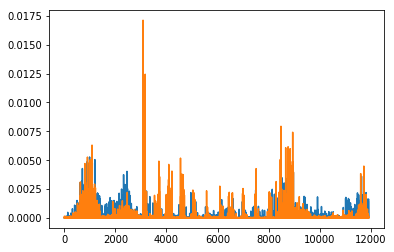

In [4]:
plt.plot(etc_feature_importance)
plt.plot(rfc_feature_importance)

### Select features

In [5]:
model_etc = SelectFromModel(etc_prefit, threshold='{:.3f}*mean'.format(etc_feature_percentile), prefit=True)
x_train_etc = model_etc.transform(x_train)
x_valid_etc = model_etc.transform(x_valid)

model_rfc = SelectFromModel(rfc_prefit, threshold='{:.3f}*mean'.format(rfc_feature_percentile), prefit=True)
x_train_rfc = model_rfc.transform(x_train)
x_valid_rfc = model_rfc.transform(x_valid)

linear_svc_etc = LinearSVC(C=1e-2, fit_intercept=True, random_state=0)
linear_svc_etc.fit(x_train_etc, y_train)
y_valid_predict_etc = linear_svc_etc.predict(x_valid_etc)
etc_acc = accuracy_score(y_valid, y_valid_predict_etc)
print('Accuracy for features from ExtraTreesClassifier is {:.3f}'.format(etc_acc))

linear_svc_rfc = LinearSVC(C=1e-2, fit_intercept=True, random_state=0)
linear_svc_rfc.fit(x_train_rfc, y_train)
y_valid_predict_rfc = linear_svc_rfc.predict(x_valid_rfc)
rfc_acc = accuracy_score(y_valid, y_valid_predict_rfc)
print('Accuracy for features from RandomForestClassifier is {:.3f}'.format(rfc_acc))


Accuracy for features from ExtraTreesClassifier is 0.987
Accuracy for features from RandomForestClassifier is 0.988


In [6]:
x_test_rfc = model_rfc.transform(x_test)

In [7]:
with open('data_rfc.p', 'wb') as pfile:
    pickle.dump({'x_train': x_train_rfc, 'y_train': y_train, 
                 'x_valid': x_valid_rfc, 'y_valid': y_valid,
                 'x_test': x_test_rfc, 'y_test': y_test}, pfile, pickle.HIGHEST_PROTOCOL)

In [8]:
with open('models.p', 'wb') as pfile:
    pickle.dump({'linear_svc_rfc': linear_svc_rfc, 
                 'scaler': scaler, 
                 'model_rfc': model_rfc}, pfile, pickle.HIGHEST_PROTOCOL)
    